In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [11]:
IMAGE_SIZE=150
batch_size=32

In [3]:
import keras
print(keras.__version__)
!pip install --upgrade keras

3.4.1


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'PHOTO',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical') 

Found 613 images belonging to 4 classes.


In [14]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
   "PHOTO",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
) 

Found 616 files belonging to 4 classes.


In [16]:
class_names=dataset.class_names
class_names # ['Sachien_Sir' :'Virat_SIR']
            

['Sachien_Sir', 'Sadguru', 'Sara_mahan', 'Virat_SIR']

In [17]:
len(dataset)

20

In [18]:
for image_batch,label_batch in dataset.take(1): # it will take only one batch 
    print(image_batch.shape)
    print(image_batch[0].numpy()) 
    print(label_batch.numpy())

(32, 150, 150, 3)
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[0 3 3 3 1 3 1 3 3 3 3 0 2 0 3 1 3 3 2 0 3 1 3 1 1 3 1 1 3 2 0 2]


In [19]:
for element in dataset:
    print(element)
    break


(<tf.Tensor: shape=(32, 150, 150, 3), dtype=float32, numpy=
array([[[[ 55.399998 ,  55.399998 ,  55.399998 ],
         [ 49.699997 ,  49.699997 ,  49.699997 ],
         [ 47.43333  ,  47.43333  ,  47.43333  ],
         ...,
         [ 27.033276 ,  48.033276 ,  33.033276 ],
         [ 13.529654 ,  28.449589 ,  15.7196045],
         [171.63083  , 183.63083  , 171.63083  ]],

        [[ 56.6      ,  56.6      ,  56.6      ],
         [ 51.11     ,  51.11     ,  51.11     ],
         [ 48.88333  ,  48.88333  ,  48.88333  ],
         ...,
         [ 15.233337 ,  35.93334  ,  21.833338 ],
         [ 16.799616 ,  32.70961  ,  20.30961  ],
         [150.36049  , 162.36049  , 150.9605   ]],

        [[ 58.083332 ,  58.083332 ,  58.083332 ],
         [ 53.3      ,  53.3      ,  53.3      ],
         [ 51.666668 ,  51.666668 ,  51.666668 ],
         ...,
         [ 23.333374 ,  43.166687 ,  31.166687 ],
         [ 18.199524 ,  32.699432 ,  22.299469 ],
         [128.88367  , 140.88367  , 130.8836

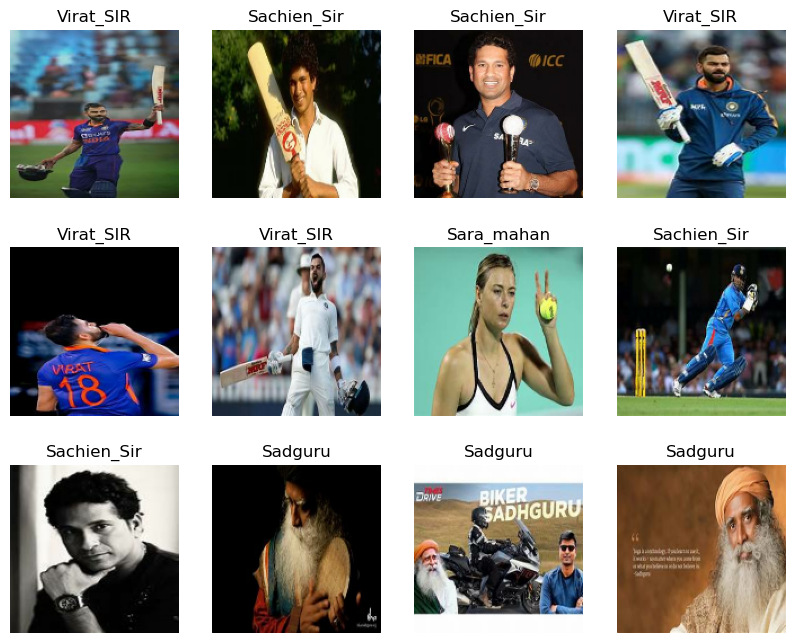

In [20]:
plt.figure(figsize=(10, 8))  # Correct figsize parameter with a tuple
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()  # Show the plot

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds),len(val_ds),len(test_ds)

(16, 2, 2)

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [27]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
CHANNELS=3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model=Sequential()
model.add(resize_and_rescale)
model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(4,activation='softmax'))

C:\Users\Sagar\anaconda3\file\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy']) 

In [37]:
history=model.fit(train_ds,epochs=40,validation_data=val_ds, batch_size=BATCH_SIZE,verbose=1)

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 788ms/step - accuracy: 0.8077 - loss: 0.4638 - val_accuracy: 0.3594 - val_loss: 3.0217
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 767ms/step - accuracy: 0.8346 - loss: 0.4221 - val_accuracy: 0.4375 - val_loss: 4.2313
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step - accuracy: 0.7999 - loss: 0.4557 - val_accuracy: 0.5625 - val_loss: 2.9300
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 767ms/step - accuracy: 0.8458 - loss: 0.4149 - val_accuracy: 0.5625 - val_loss: 2.6653
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 817ms/step - accuracy: 0.8157 - loss: 0.5497 - val_accuracy: 0.6406 - val_loss: 2.3876
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 785ms/step - accuracy: 0.8708 - loss: 0.3336 - val_accuracy: 0.5312 - val_loss: 2.1903
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 782ms/step - accuracy: 0.8520 - loss: 0.4014 - val_accuracy: 0.5312 - val_loss: 1.5674
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 855ms/step - accuracy: 0.8875 - loss: 0.3461 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


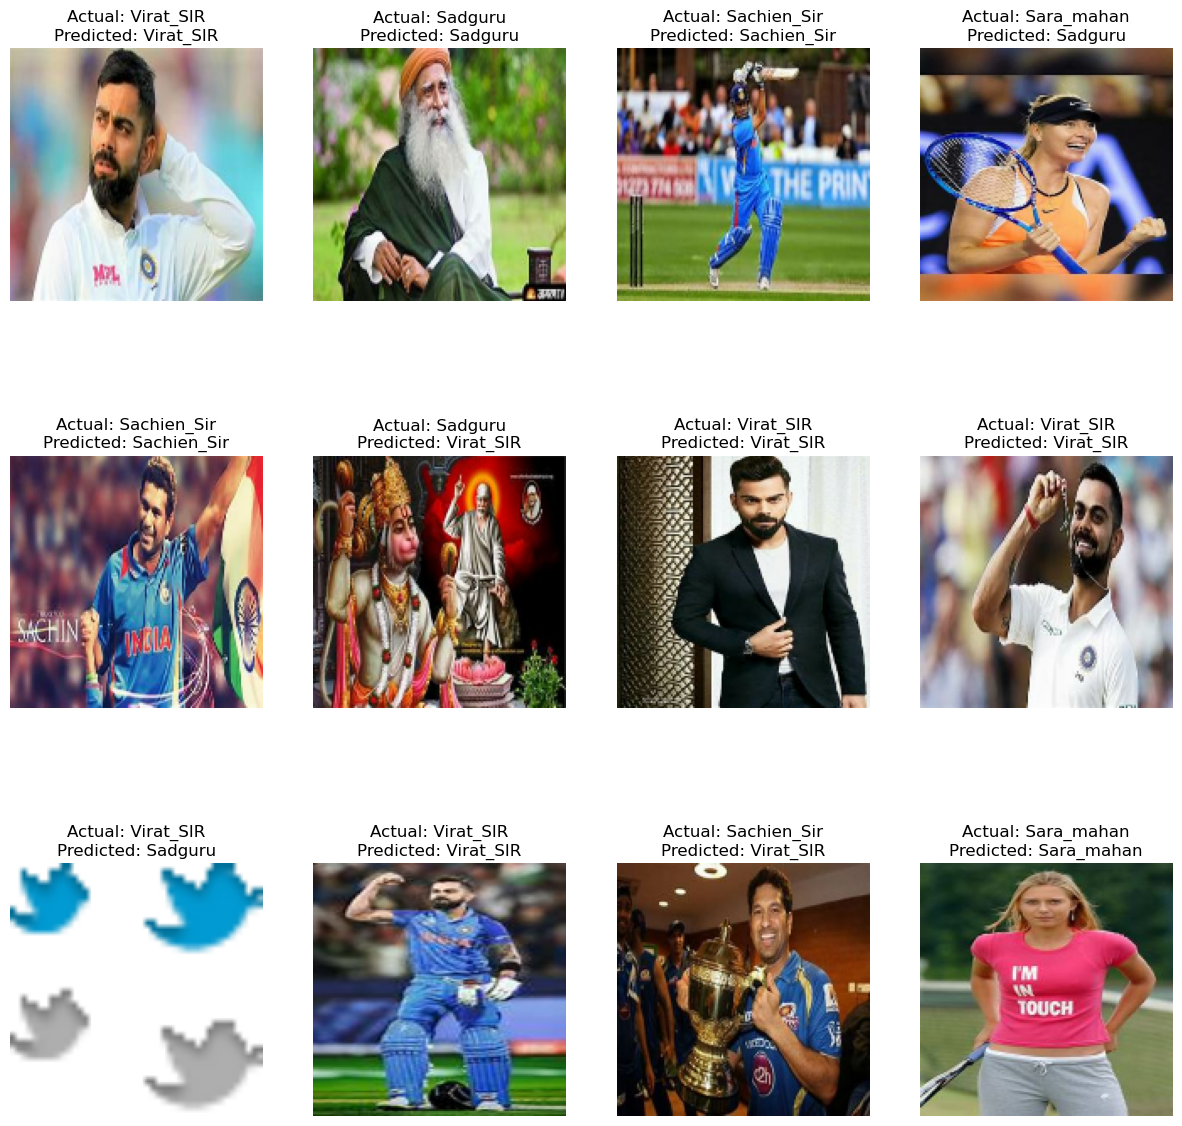

In [38]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in val_ds.take(1):
    # Make predictions on the batch
    predictions = model.predict(image_batch)
    
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        name = class_names[label_batch[i]]
       
        
        # Get the predicted label for each image in the batch
        predicted_label = np.argmax(predictions[i])
        predicted_name = class_names[predicted_label]
        
        
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(f"Actual: {name}\nPredicted: {predicted_name}")
        plt.axis("off")
plt.show()

In [49]:
from PIL import Image

image = Image.open("C:/Users/Sagar/OneDrive/Desktop/Photo_Recognization/PHOTO/Sachin.jpeg")



def predict_image(image): 
    resized_image = image.resize((150,150))
    # Convert image to numpy array
    image_array = np.array(resized_image)

    # Prepare the image for prediction
    image_array = image_array / 255.0  # Normalize if required
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(image_array)
    predicted_label = np.argmax(predictions[0])
    predicted_name = class_names[predicted_label]
    print(predicted_name)


In [48]:
predicted_name = predict_image(image)
print(predicted_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Sadguru


In [46]:
joblib.dump(model, 'model.joblib')

['model.joblib']

In [47]:
import joblib
import tensorflow as tf
from tensorflow import keras

# Load the model using joblib
model = joblib.load('model.joblib')  # Ensure this path is correct

# Check if the model is a Keras model
if isinstance(model, keras.Model):
    # Save the model in .h5 format
    model.save('model.h5')
    print("Model saved successfully in model.h5 format.")
else:
    print("The model is not a Keras model and cannot be saved using Keras save method.")

Model saved successfully in model.h5 format.


In [51]:
class_names

['Sachien_Sir', 'Sadguru', 'Sara_mahan', 'Virat_SIR']

In [50]:
import joblib

# Save the list to a file
joblib.dump(class_names, 'class_names.joblib')

['class_names.joblib']